# BIKE SHARING DEMAND

### 1. 출처 : [Kaggle - Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand)


### 2. 목표 :  과거 사용 패턴과 날씨 데이터를 이용하여 자전거 대여 수요(count)를 예측


### 3. Column 설명

  * **datetime** - 시간. 연-월-일 시:분:초 로 표현
  * **season** - 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
  * **holiday** - 1 = 공휴일, 0 = 공휴일이 아님
  * **workingday** - 1 = 근무일, 0 = 근무일이 아님
  * **weather** - 날씨
    * 1: 아주 깨끗한 날씨입니다. 또는 아주 약간의 구름이 끼어있습니다.
    * 2: 약간의 안개와 구름이 끼어있는 날씨입니다.
    * 3: 약간의 눈, 비가 오거나 천둥이 칩니다.
    * 4: 아주 많은 비가 오거나 우박이 내립니다.
  * **temp** - 섭씨(Celsius) 온도
  * **atemp** - 섭씨(Celsius) 체감 온도
  * **humidity** - 습도
  * **windspeed** - 풍속
  * **casual** - 비회원(non-registered)의 자전거 대여량.
  * **registered** - 회원(registered)의 자전거 대여량.
  * **count** - 총 자전거 대여랑.

## LIbrary 불러오기

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

from IPython.display import set_matplotlib_formats

%matplotlib inline

plt.style.use('seaborn')
sns.set(font_scale=1.5)

sns.set(style = "whitegrid")

# Mac OS의 경우 AppleGothic 설정
# 윈도우의 경우, 나눔폰트가 있는 경우 'NanumGothic' 없는 경우에는 'Malgun Gothic'을 사용
matplotlib.rc('font', family='AppleGothic')
#matplotlib.rc('font', family='Malgun Gothic')

# 폰트를 바꿀 경우 마이너스가 표시되지 않는 경우도 있는데 이를 막아주는 코드
matplotlib.rc('axes', unicode_minus=False)
matplotlib.rcParams['axes.unicode_minus'] = False

# retina 옵션을 통해 해상도 향상
set_matplotlib_formats('retina')

# 화면에 출력하는 데이터 프레임의 최대 row 수를 500으로 설정
pd.set_option('display.max_rows', 500)

# 화면에 출력하는 데이터 프레임의 최대 column 수를 500으로 설정
pd.set_option('display.max_columns', 500)

## Load Dataset

In [3]:
# train 데이터 읽어오기

train = pd.read_csv("data/train.csv")

print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# test 데이터 읽어오기

test = pd.read_csv("data/test.csv")

print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## 전처리(Preprocessing)

### datetime 컬럼 전처리

In [5]:
# train 데이터의 datetime 컬럼을 문자열(string)에서 날짜/시간(datetime) 으로 변경

train["datetime"] = pd.to_datetime(train["datetime"])

# train 데이터의 datetime 컬럼을 연, 월, 일, 시, 분, 초 컬럼으로 분리

train["datetime-year"] = train["datetime"].dt.year
train["datetime-month"] = train["datetime"].dt.month
train["datetime-day"] = train["datetime"].dt.day
train["datetime-hour"] = train["datetime"].dt.hour
train["datetime-minute"] = train["datetime"].dt.minute
train["datetime-second"] = train["datetime"].dt.second

print(train.shape)
train[["datetime", "datetime-year", "datetime-month", "datetime-day",
       "datetime-hour", "datetime-minute", "datetime-second"]].head()

(10886, 18)


,datetime,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second
0,2011-01-01 00:00:00,2011,1,1,0,0,0
1,2011-01-01 01:00:00,2011,1,1,1,0,0
2,2011-01-01 02:00:00,2011,1,1,2,0,0
3,2011-01-01 03:00:00,2011,1,1,3,0,0
4,2011-01-01 04:00:00,2011,1,1,4,0,0


In [6]:
# test 데이터의 datetime 컬럼을 문자열(string)에서 날짜/시간(datetime) 으로 변경

test["datetime"] = pd.to_datetime(test["datetime"])

# train 데이터의 datetime 컬럼을 연, 월, 일, 시, 분, 초 컬럼으로 분리

test["datetime-year"] = test["datetime"].dt.year
test["datetime-month"] = test["datetime"].dt.month
test["datetime-day"] = test["datetime"].dt.day
test["datetime-hour"] = test["datetime"].dt.hour
test["datetime-minute"] = test["datetime"].dt.minute
test["datetime-second"] = test["datetime"].dt.second

print(test.shape)
test[["datetime", "datetime-year", "datetime-month", "datetime-day",
       "datetime-hour", "datetime-minute", "datetime-second"]].head()

(6493, 15)


,datetime,datetime-year,datetime-month,datetime-day,datetime-hour,datetime-minute,datetime-second
0,2011-01-20 00:00:00,2011,1,20,0,0,0
1,2011-01-20 01:00:00,2011,1,20,1,0,0
2,2011-01-20 02:00:00,2011,1,20,2,0,0
3,2011-01-20 03:00:00,2011,1,20,3,0,0
4,2011-01-20 04:00:00,2011,1,20,4,0,0


## E.D.A(탐험적 데이터 분석 / Explortory Data Analysis)

### season 컬럼 분석

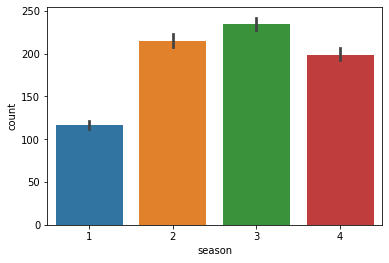

In [7]:
sns.barplot(data = train, x = "season", y = "count")

# 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울

# 계절에 따른 자전거 대여량의 영향이 있음

In [8]:
# one hot encoding 변환

train["season-spring"] = train["season"] == 1
train["season-summer"] = train["season"] == 2
train["season-autumn"] = train["season"] == 3
train["season-winter"] = train["season"] == 4

train[["season", "season-spring", "season-summer", "season-autumn", "season-winter"]].head()

,season,season-spring,season-summer,season-autumn,season-winter
0,1,True,False,False,False
1,1,True,False,False,False
2,1,True,False,False,False
3,1,True,False,False,False
4,1,True,False,False,False


In [9]:

test["season-spring"] = test["season"] == 1
test["season-summer"] = test["season"] == 2
test["season-autumn"] = test["season"] == 3
test["season-winter"] = test["season"] == 4

test[["season", "season-spring", "season-summer", "season-autumn", "season-winter"]].head()

,season,season-spring,season-summer,season-autumn,season-winter
0,1,True,False,False,False
1,1,True,False,False,False
2,1,True,False,False,False
3,1,True,False,False,False
4,1,True,False,False,False


### holiday, workingday 컬럼 분석

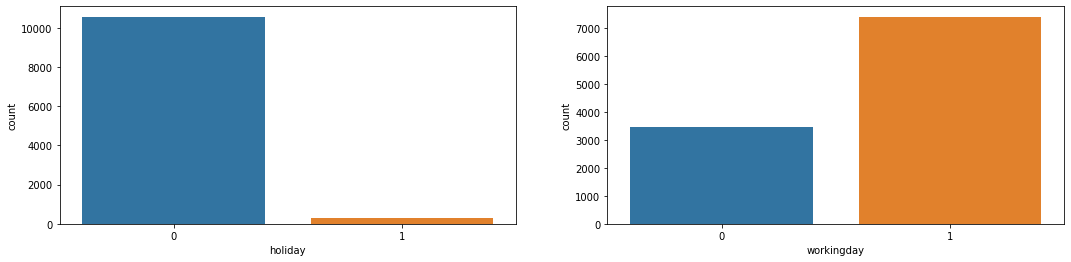

In [10]:
# 여러 개의 시각화를 한 화면에 띄우기

figure,((ax1, ax2)) = plt.subplots(ncols = 2)

# 시각화 사이즈 설정

figure.set_size_inches(18, 4)

sns.countplot(data = train, x = "holiday", ax = ax1)
sns.countplot(data = train, x = "workingday", ax = ax2)

# 0 = 공휴일, 1 = 근무일

# 공휴일과 근무일에 따른 자전거 대여량의 영향이 있음

### datetime 컬럼 분석

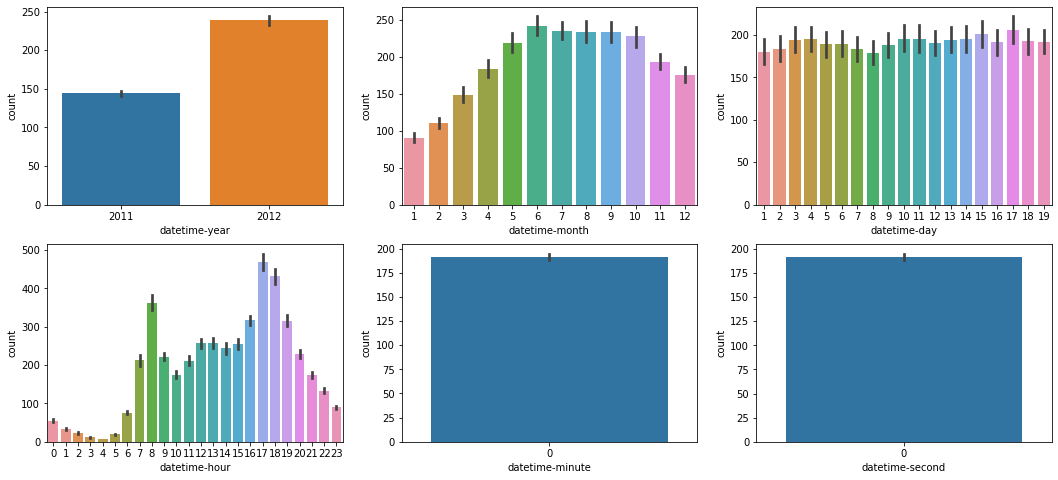

In [11]:
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)

figure.set_size_inches(18, 8)

sns.barplot(data = train, x = "datetime-year", y = "count", ax = ax1)
sns.barplot(data = train, x = "datetime-month", y = "count", ax = ax2)
sns.barplot(data = train, x = "datetime-day", y = "count", ax = ax3)
sns.barplot(data = train, x = "datetime-hour", y = "count", ax = ax4)
sns.barplot(data = train, x = "datetime-minute", y = "count", ax = ax5)
sns.barplot(data = train, x = "datetime-second", y = "count", ax = ax6)

# datetime-day 는 train 데이터에 1 ~ 19일까지 밖에 없고, test 데이터에는 20 ~ 31일까지 있음 -> feature 사용 불가
# datetime-minute, second 는 데이터가 없음 -> feature 사용 불가

### weather 컬럼 분석

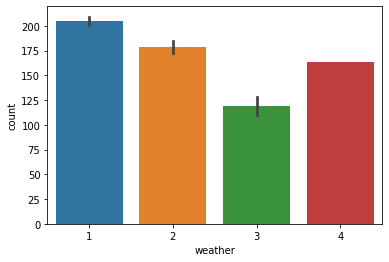

In [12]:
sns.barplot(data = train, x = "weather", y = "count")

# 1 = 가장 좋은 날씨, 2 = 적당히 좋은 날씨, 3 = 적당히 나쁜 날씨, 4 = 매우 나쁜 날씨
# 4의 경우 신뢰구간이 없으므로 3으로 변경

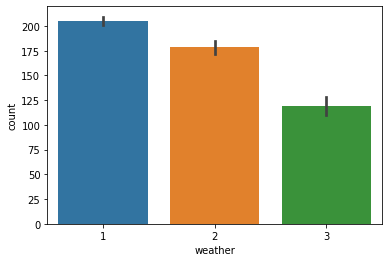

In [13]:
train["weather"] = train["weather"].replace(4, 3)

sns.barplot(data = train, x = "weather", y = "count")

In [14]:
test["weather"] = test["weather"].replace(4, 3)

In [15]:
# one hot encoding 변환

train["weather-good"] = train["weather"] == 1
train["weather-notbad"] = train["weather"] == 2
train["weather-bad"] = train["weather"] == 3

train[["weather", "weather-good", "weather-notbad", "weather-bad"]].head()

,weather,weather-good,weather-notbad,weather-bad
0,1,True,False,False
1,1,True,False,False
2,1,True,False,False
3,1,True,False,False
4,1,True,False,False


In [16]:
test["weather-good"] = test["weather"] == 1
test["weather-notbad"] = test["weather"] == 2
test["weather-bad"] = test["weather"] == 3

test[["weather", "weather-good", "weather-notbad", "weather-bad"]].head()

,weather,weather-good,weather-notbad,weather-bad
0,1,True,False,False
1,1,True,False,False
2,1,True,False,False
3,1,True,False,False
4,1,True,False,False


### temp컬럼 분석

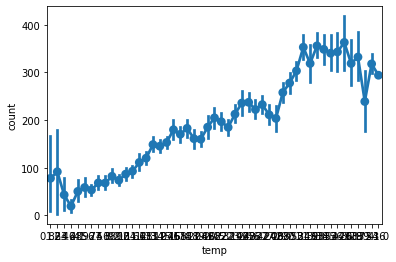

In [17]:
sns.pointplot(data = train, x = "temp", y = "count")

In [18]:
# temp 종류 출력

train["temp"].unique()

array([ 9.84,  9.02,  8.2 , 13.12, 15.58, 14.76, 17.22, 18.86, 18.04,
       16.4 , 13.94, 12.3 , 10.66,  6.56,  5.74,  7.38,  4.92, 11.48,
        4.1 ,  3.28,  2.46, 21.32, 22.96, 23.78, 24.6 , 19.68, 22.14,
       20.5 , 27.06, 26.24, 25.42, 27.88, 28.7 , 30.34, 31.16, 29.52,
       33.62, 35.26, 36.9 , 32.8 , 31.98, 34.44, 36.08, 37.72, 38.54,
        1.64,  0.82, 39.36, 41.  ])

In [19]:
# temp 반올림 후 새로운 컬럼에 할당

train["temp(int)"] = train["temp"].round()

print(train.shape)
train["temp(int)"].head()

(10886, 26)


0    10.0
1     9.0
2     9.0
3    10.0
4    10.0
Name: temp(int), dtype: float64

In [20]:
# test 데이터에 반영

test["temp(int)"] = test["temp"].round()
test["temp(int)"].head()

0    11.0
1    11.0
2    11.0
3    11.0
4    11.0
Name: temp(int), dtype: float64

### atemp 컬럼 분석

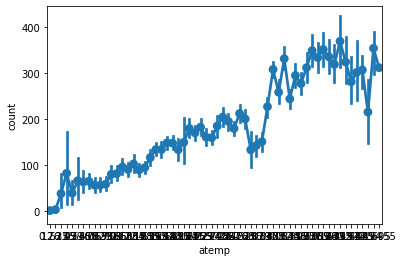

In [21]:
sns.pointplot(data = train, x = "atemp", y = "count")

In [22]:
# atemp 종류 출력

train["atemp"].unique()

array([14.395, 13.635, 12.88 , 17.425, 19.695, 16.665, 21.21 , 22.725,
       21.97 , 20.455, 11.365, 10.605,  9.85 ,  8.335,  6.82 ,  5.305,
        6.06 ,  9.09 , 12.12 ,  7.575, 15.91 ,  3.03 ,  3.79 ,  4.545,
       15.15 , 18.18 , 25.   , 26.515, 27.275, 29.545, 23.485, 25.76 ,
       31.06 , 30.305, 24.24 , 18.94 , 31.82 , 32.575, 33.335, 28.79 ,
       34.85 , 35.605, 37.12 , 40.15 , 41.665, 40.91 , 39.395, 34.09 ,
       28.03 , 36.365, 37.88 , 42.425, 43.94 , 38.635,  1.515,  0.76 ,
        2.275, 43.18 , 44.695, 45.455])

In [23]:
# atemp 반올림 후 새로운 컬럼에 할당

train["atemp(int)"] = train["atemp"].round()

print(train.shape)
train["atemp(int)"].head()

(10886, 27)


0    14.0
1    14.0
2    14.0
3    14.0
4    14.0
Name: atemp(int), dtype: float64

In [24]:
# test 데이터에 반영

test["atemp(int)"] = test["atemp"].round()
test["atemp(int)"].head()

0    11.0
1    14.0
2    14.0
3    13.0
4    13.0
Name: atemp(int), dtype: float64

### temp(int), atemp(int) 컬럼 비교 

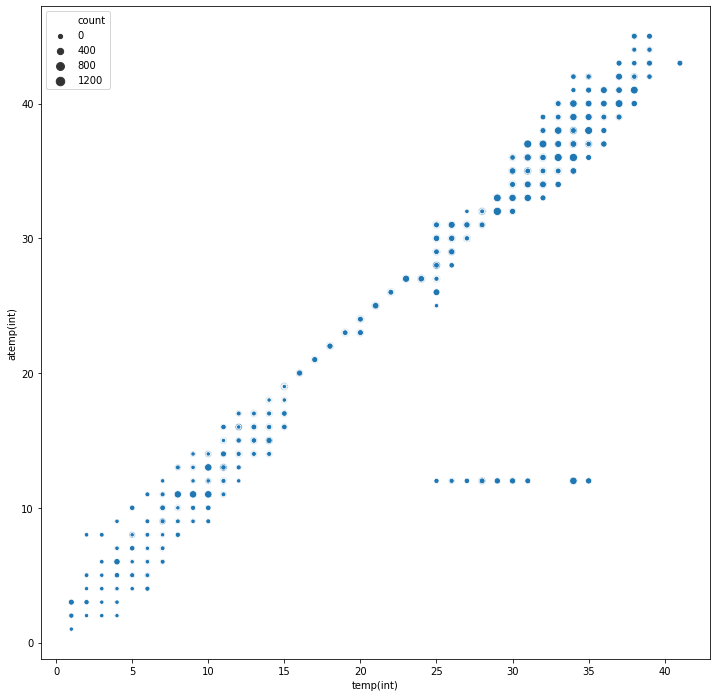

In [25]:
plt.figure(figsize = (12, 12))

sns.scatterplot(data = train, x = "temp(int)", y = "atemp(int)", size = "count")

In [26]:
# 정수형(int)으로 변환한 온도(temp)와 체감온도(atemp)를 빼서
# 두 값의 차이를 나타내는 temp(difference)라는 새로운 컬럼 추가

train["temp(difference)"] = train["temp(int)"] - train["atemp(int)"]
train[["temp(int)", "atemp(int)", "temp(difference)"]].head()

,temp(int),atemp(int),temp(difference)
0,10.0,14.0,-4.0
1,9.0,14.0,-5.0
2,9.0,14.0,-5.0
3,10.0,14.0,-4.0
4,10.0,14.0,-4.0


In [27]:
train["temp(difference)"].value_counts()

-4.0     5106
-3.0     2097
-2.0     1415
-5.0     1049
-1.0      509
-6.0      405
 0.0      219
 1.0       32
-7.0       21
 22.0       5
-8.0        5
 14.0       5
 2.0        4
 16.0       3
 15.0       3
 18.0       3
 23.0       2
 17.0       1
 13.0       1
 19.0       1
Name: temp(difference), dtype: int64

In [28]:
# 모수가 적은 데이터를 합치기

train.loc[train["temp(difference)"] < -6, "temp(difference)"] = -6
train.loc[train["temp(difference)"] > 0, "temp(difference)"] = 0

train["temp(difference)"].value_counts()

-4.0    5106
-3.0    2097
-2.0    1415
-5.0    1049
-1.0     509
-6.0     431
 0.0     279
Name: temp(difference), dtype: int64

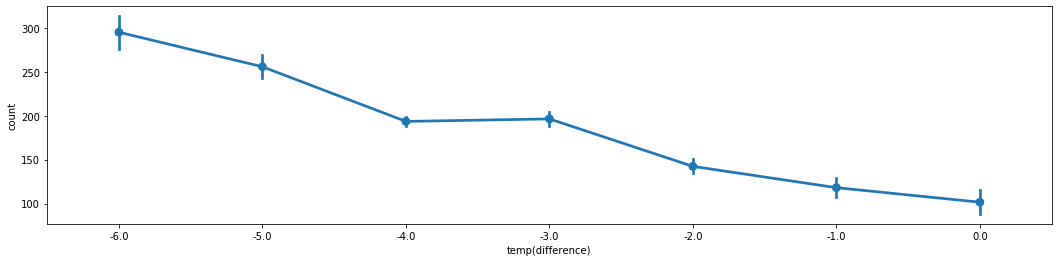

In [29]:
plt.figure(figsize = (18, 4))
sns.pointplot(data = train, x = "temp(difference)", y = "count")

# temp 와 atemp 의 차이가 클수록 자전거를 많이 빌린다는 것을 알 수 있음

In [30]:
# test 데이터에 반영

test["temp(difference)"] = test["temp(int)"] - test["atemp(int)"]
test[["temp(int)", "atemp(int)", "temp(difference)"]].head()

,temp(int),atemp(int),temp(difference)
0,11.0,11.0,0.0
1,11.0,14.0,-3.0
2,11.0,14.0,-3.0
3,11.0,13.0,-2.0
4,11.0,13.0,-2.0


In [31]:
test["temp(difference)"].value_counts()

-4.0     2883
-3.0     1308
-2.0      904
-5.0      560
-1.0      409
-6.0      211
 0.0      156
-7.0       22
-8.0       17
-9.0        8
 1.0        6
-11.0       4
-10.0       4
 2.0        1
Name: temp(difference), dtype: int64

In [32]:
test.loc[test["temp(difference)"] < -6, "temp(difference)"] = -6
test.loc[test["temp(difference)"] > 0, "temp(difference)"] = 0

test["temp(difference)"].value_counts()

-4.0    2883
-3.0    1308
-2.0     904
-5.0     560
-1.0     409
-6.0     266
 0.0     163
Name: temp(difference), dtype: int64

### humidity 컬럼 분석

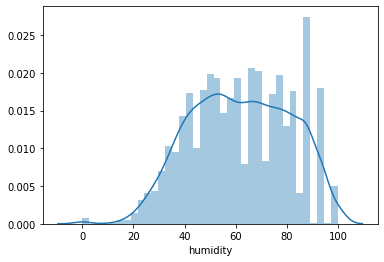

In [33]:
sns.distplot(train["humidity"])

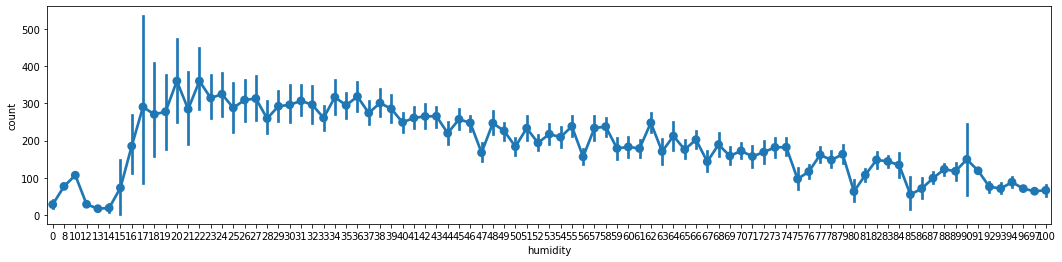

In [34]:
plt.figure(figsize = (18, 4))

sns.pointplot(data = train, x = "humidity", y = "count")

In [35]:
train["humidity"].unique()

array([ 81,  80,  75,  86,  76,  77,  72,  82,  88,  87,  94, 100,  71,
        66,  57,  46,  42,  39,  44,  47,  50,  43,  40,  35,  30,  32,
        64,  69,  55,  59,  63,  68,  74,  51,  56,  52,  49,  48,  37,
        33,  28,  38,  36,  93,  29,  53,  34,  54,  41,  45,  92,  62,
        58,  61,  60,  65,  70,  27,  25,  26,  31,  73,  21,  24,  23,
        22,  19,  15,  67,  10,   8,  12,  14,  13,  17,  16,  18,  20,
        85,   0,  83,  84,  78,  79,  89,  97,  90,  96,  91])

### windspeed 컬럼 분석

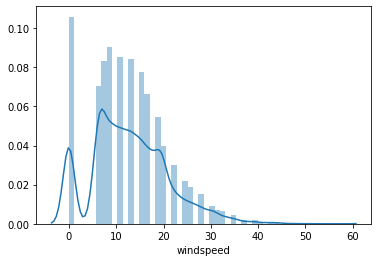

In [36]:
sns.distplot(train["windspeed"])

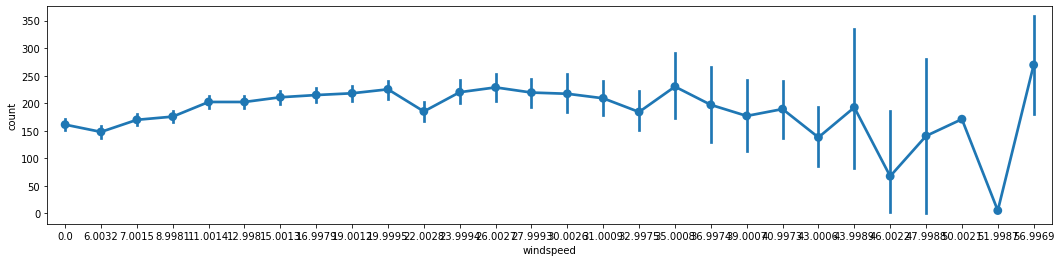

In [37]:
plt.figure(figsize = (18, 4))

sns.pointplot(data = train, x = "windspeed", y = "count")

In [38]:
# windspeed 의 값을 반올림 하여 정수(int)로 변환

train["windspeed(int)"] = train["windspeed"].round()

train["windspeed(int)"].value_counts()

0.0     1313
9.0     1120
11.0    1057
13.0    1042
7.0     1034
15.0     961
6.0      872
17.0     824
19.0     676
20.0     492
22.0     372
24.0     274
26.0     235
28.0     187
30.0     111
31.0      89
33.0      80
35.0      58
39.0      27
37.0      22
43.0      12
41.0      11
44.0       8
46.0       3
48.0       2
57.0       2
52.0       1
50.0       1
Name: windspeed(int), dtype: int64

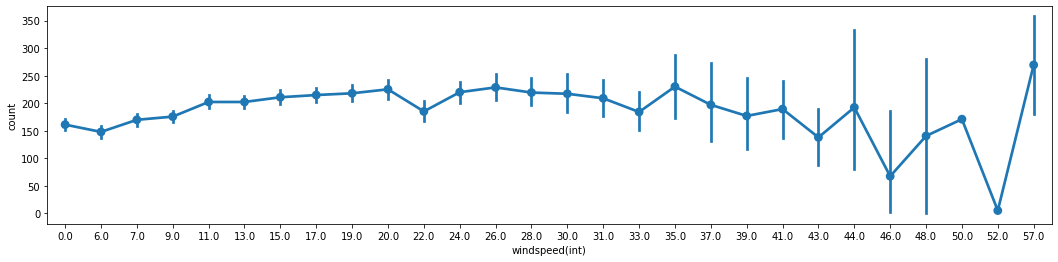

In [39]:
plt.figure(figsize = (18, 4))

sns.pointplot(data = train, x = "windspeed(int)", y = "count")

# windspeed(int) 는 바람이 적당 할수록 자전거 대여량이 많다는 점이 확인 되나, 신뢰 구간의 범위가 넓은 편

In [40]:
# test 데이터 반영

test["windspeed(int)"] = test["windspeed"].round()
test["windspeed(int)"].value_counts()

0.0     867
11.0    638
9.0     618
13.0    615
7.0     583
6.0     553
15.0    552
17.0    471
19.0    372
20.0    316
22.0    230
24.0    186
26.0    146
28.0    109
30.0     65
31.0     57
33.0     32
35.0     26
37.0     17
39.0     17
41.0     12
44.0      3
43.0      2
54.0      2
46.0      2
50.0      1
56.0      1
Name: windspeed(int), dtype: int64

In [41]:
print(train.groupby("season")["windspeed(int)"].mean().round())

season
1    15.0
2    13.0
3    12.0
4    12.0
Name: windspeed(int), dtype: float64


In [42]:
train["windspeed-encode"] = train["windspeed(int)"]

train.loc[(train["windspeed(int)"] == 0) & (train["season"] == 1), "windspeed-encode"] = 15
train.loc[(train["windspeed(int)"] == 0) & (train["season"] == 2), "windspeed-encode"] = 13
train.loc[(train["windspeed(int)"] == 0) & (train["season"] == 3), "windspeed-encode"] = 12
train.loc[(train["windspeed(int)"] == 0) & (train["season"] == 4), "windspeed-encode"] = 12

print(train.shape)
train[["windspeed(int)", "windspeed-encode"]].head()


(10886, 30)


,windspeed(int),windspeed-encode
0,0.0,15.0
1,0.0,15.0
2,0.0,15.0
3,0.0,15.0
4,0.0,15.0


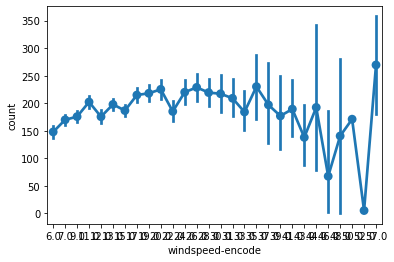

In [43]:
sns.pointplot(data = train, x = "windspeed-encode", y = "count")

In [44]:
# 모수가 적은 데이터를 하나로 합치기

train["windspeed-encode"].value_counts()

13.0    1310
15.0    1224
9.0     1120
11.0    1057
7.0     1034
6.0      872
17.0     824
12.0     782
19.0     676
20.0     492
22.0     372
24.0     274
26.0     235
28.0     187
30.0     111
31.0      89
33.0      80
35.0      58
39.0      27
37.0      22
43.0      12
41.0      11
44.0       8
46.0       3
48.0       2
57.0       2
50.0       1
52.0       1
Name: windspeed-encode, dtype: int64

In [45]:
train.loc[train["windspeed-encode"] > 30, "windspeed-encode"] = 30

train["windspeed-encode"].value_counts()

13.0    1310
15.0    1224
9.0     1120
11.0    1057
7.0     1034
6.0      872
17.0     824
12.0     782
19.0     676
20.0     492
30.0     427
22.0     372
24.0     274
26.0     235
28.0     187
Name: windspeed-encode, dtype: int64

In [46]:
# test 데이터 반영

print(test.groupby("season")["windspeed(int)"].mean().round())

season
1    14.0
2    14.0
3    11.0
4    11.0
Name: windspeed(int), dtype: float64


In [47]:
test["windspeed-encode"] = test["windspeed(int)"]

test.loc[(test["windspeed(int)"] == 0) & (test["season"] == 1), "windspeed-encode"] = 14
test.loc[(test["windspeed(int)"] == 0) & (test["season"] == 2), "windspeed-encode"] = 14
test.loc[(test["windspeed(int)"] == 0) & (test["season"] == 3), "windspeed-encode"] = 11
test.loc[(test["windspeed(int)"] == 0) & (test["season"] == 4), "windspeed-encode"] = 11

print(test.shape)
test[["windspeed(int)", "windspeed-encode"]].head()


(6493, 27)


,windspeed(int),windspeed-encode
0,26.0,26.0
1,0.0,14.0
2,0.0,14.0
3,11.0,11.0
4,11.0,11.0


In [48]:
test["windspeed-encode"].value_counts()

11.0    1202
9.0      618
13.0     615
7.0      583
6.0      553
15.0     552
17.0     471
19.0     372
20.0     316
14.0     303
22.0     230
24.0     186
26.0     146
28.0     109
30.0      65
31.0      57
33.0      32
35.0      26
37.0      17
39.0      17
41.0      12
44.0       3
43.0       2
54.0       2
46.0       2
50.0       1
56.0       1
Name: windspeed-encode, dtype: int64

In [49]:
test.loc[test["windspeed-encode"] > 28, "windspeed-encode"] = 28

test["windspeed-encode"].value_counts()

11.0    1202
9.0      618
13.0     615
7.0      583
6.0      553
15.0     552
17.0     471
19.0     372
28.0     346
20.0     316
14.0     303
22.0     230
24.0     186
26.0     146
Name: windspeed-encode, dtype: int64

### casual, registered 컬럼 분석

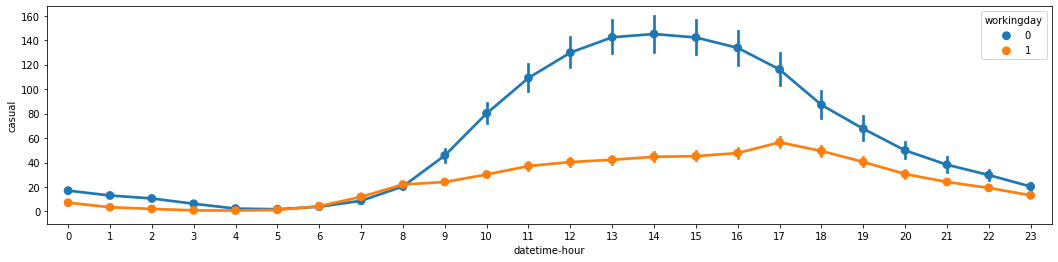

In [50]:
plt.figure(figsize = (18, 4))

sns.pointplot(data=train, x="datetime-hour", y="casual", hue="workingday")

# casual 컬럼은 근무일 보다는 공휴일에 자전거를 많이 대여하며 주로 10시 ~ 18시 사이에 빌린다는 것을 확인 

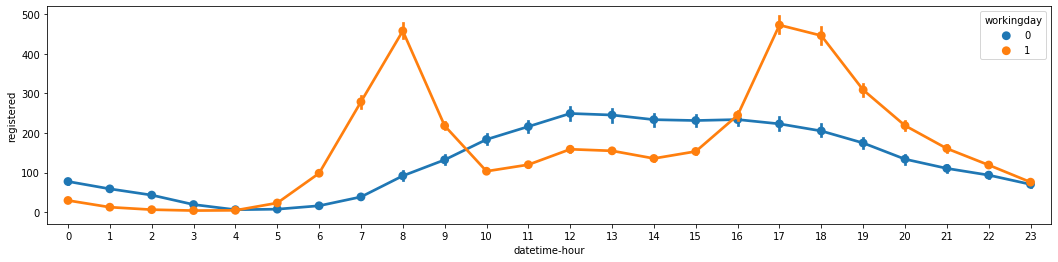

In [51]:
plt.figure(figsize = (18, 4))

sns.pointplot(data=train, x="datetime-hour", y="registered", hue="workingday")

# registered 컬럼은 공휴일 보다는 근무일에 자전거를 많이 대여하며 주로 7시 ~ 9시와 17시 ~ 19시 사이에 빌린다는 것을 확인

### datetime-dayofweek 컬럼 생성 및 분석

In [52]:
# datetime-dayofweek 컬럼 생성

train["datetime-dayofweek"] = train["datetime"].dt.day_name()

print(train.shape)
train[["datetime", "datetime-dayofweek"]].head()

(10886, 31)


,datetime,datetime-dayofweek
0,2011-01-01 00:00:00,Saturday
1,2011-01-01 01:00:00,Saturday
2,2011-01-01 02:00:00,Saturday
3,2011-01-01 03:00:00,Saturday
4,2011-01-01 04:00:00,Saturday


In [53]:
# 숫자로 변경

train["datetime-dayofweek(int)"] = train["datetime"].dt.dayofweek

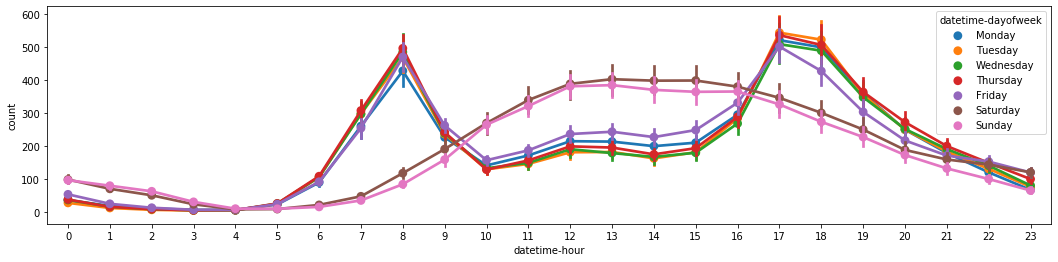

In [54]:
plt.figure(figsize = (18, 4))

dayofweek_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

sns.pointplot(data=train, x="datetime-hour", y="count", hue="datetime-dayofweek", hue_order=dayofweek_order)

# datetime-dayofweek 에 따른 자전거 대여량의 변화를 확인 할 수 있음

In [55]:
# one hot encoding

train["datetime-monday"] = train["datetime-dayofweek"] == "Monday"
train["datetime-tuesday"] = train["datetime-dayofweek"] == "Tuesday"
train["datetime-wednesday"] = train["datetime-dayofweek"] == "Wednesday"
train["datetime-thursday"] = train["datetime-dayofweek"] == "Thursday"
train["datetime-friday"] = train["datetime-dayofweek"] == "Friday"
train["datetime-saturday"] = train["datetime-dayofweek"] == "Saturday"
train["datetime-sunday"] = train["datetime-dayofweek"] == "Sunday"

print(train.shape)
train.head()

(10886, 39)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,windspeed-encode,datetime-dayofweek,datetime-dayofweek(int),datetime-monday,datetime-tuesday,datetime-wednesday,datetime-thursday,datetime-friday,datetime-saturday,datetime-sunday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,15.0,Saturday,5,False,False,False,False,False,True,False
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,15.0,Saturday,5,False,False,False,False,False,True,False
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,15.0,Saturday,5,False,False,False,False,False,True,False
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,15.0,Saturday,5,False,False,False,False,False,True,False
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,15.0,Saturday,5,False,False,False,False,False,True,False


In [56]:
# dayofweek 숫자로 변경

train["datetime-dayofweek(int)"] = train["datetime"].dt.dayofweek

train[["datetime", "datetime-dayofweek(int)"]].head()

,datetime,datetime-dayofweek(int)
0,2011-01-01 00:00:00,5
1,2011-01-01 01:00:00,5
2,2011-01-01 02:00:00,5
3,2011-01-01 03:00:00,5
4,2011-01-01 04:00:00,5


In [57]:
# test 데이터에 반영

test["datetime-dayofweek"] = test["datetime"].dt.day_name()

print(train.shape)
test[["datetime", "datetime-dayofweek"]].head()

(10886, 39)


,datetime,datetime-dayofweek
0,2011-01-20 00:00:00,Thursday
1,2011-01-20 01:00:00,Thursday
2,2011-01-20 02:00:00,Thursday
3,2011-01-20 03:00:00,Thursday
4,2011-01-20 04:00:00,Thursday


In [60]:
test["datetime-monday"] = test["datetime-dayofweek"] == "Monday"
test["datetime-tuesday"] = test["datetime-dayofweek"] == "Tuesday"
test["datetime-wednesday"] = test["datetime-dayofweek"] == "Wednesday"
test["datetime-thursday"] = test["datetime-dayofweek"] == "Thursday"
test["datetime-friday"] = test["datetime-dayofweek"] == "Friday"
test["datetime-saturday"] = test["datetime-dayofweek"] == "Saturday"
test["datetime-sunday"] = test["datetime-dayofweek"] == "Sunday"

print(test.shape)
test.head()

(6493, 36)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime-year,...,windspeed-encode,datetime-dayofweek,datetime-monday,datetime-tuesday,datetime-wednesday,datetime-thursday,datetime-friday,datetime-saturday,datetime-sunday,datetime-dayofweek(int)
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,...,26.0,Thursday,False,False,False,True,False,False,False,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,...,14.0,Thursday,False,False,False,True,False,False,False,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,...,14.0,Thursday,False,False,False,True,False,False,False,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,...,11.0,Thursday,False,False,False,True,False,False,False,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,...,11.0,Thursday,False,False,False,True,False,False,False,3


In [61]:
test["datetime-dayofweek(int)"] = test["datetime"].dt.dayofweek

test[["datetime", "datetime-dayofweek(int)"]].head()

,datetime,datetime-dayofweek(int)
0,2011-01-20 00:00:00,3
1,2011-01-20 01:00:00,3
2,2011-01-20 02:00:00,3
3,2011-01-20 03:00:00,3
4,2011-01-20 04:00:00,3


## Train

In [106]:
feature_name = ["season-spring", "season-summer", "season-autumn", "season-winter", "holiday", "workingday",
                "weather-good", "weather-notbad", "weather-bad", "datetime-year", "datetime-dayofweek(int)",
                "datetime-hour", "temp(int)", "atemp(int)", "temp(difference)", "humidity", "windspeed-encode"]

#feature_name = ["season", "holiday", "workingday", "weather",
#                 "temp", "atemp", "humidity", "windspeed",
#                 "datetime-year", "datetime-hour", "datetime-dayofweek(int)"]

feature_name

['season-spring',
 'season-summer',
 'season-autumn',
 'season-winter',
 'holiday',
 'workingday',
 'weather-good',
 'weather-notbad',
 'weather-bad',
 'datetime-year',
 'datetime-dayofweek(int)',
 'datetime-hour',
 'temp(int)',
 'atemp(int)',
 'temp(difference)',
 'humidity',
 'windspeed-encode']

In [107]:
X_train = train[feature_name]

print(X_train.shape)
X_train.head()

(10886, 17)


,season-spring,season-summer,season-autumn,season-winter,holiday,workingday,weather-good,weather-notbad,weather-bad,datetime-year,datetime-dayofweek(int),datetime-hour,temp(int),atemp(int),temp(difference),humidity,windspeed-encode
0,True,False,False,False,0,0,True,False,False,2011,5,0,10.0,14.0,-4.0,81,15.0
1,True,False,False,False,0,0,True,False,False,2011,5,1,9.0,14.0,-5.0,80,15.0
2,True,False,False,False,0,0,True,False,False,2011,5,2,9.0,14.0,-5.0,80,15.0
3,True,False,False,False,0,0,True,False,False,2011,5,3,10.0,14.0,-4.0,75,15.0
4,True,False,False,False,0,0,True,False,False,2011,5,4,10.0,14.0,-4.0,75,15.0


In [108]:
X_test = test[feature_name]

print(X_test.shape)
X_test.head()

(6493, 17)


,season-spring,season-summer,season-autumn,season-winter,holiday,workingday,weather-good,weather-notbad,weather-bad,datetime-year,datetime-dayofweek(int),datetime-hour,temp(int),atemp(int),temp(difference),humidity,windspeed-encode
0,True,False,False,False,0,1,True,False,False,2011,3,0,11.0,11.0,0.0,56,26.0
1,True,False,False,False,0,1,True,False,False,2011,3,1,11.0,14.0,-3.0,56,14.0
2,True,False,False,False,0,1,True,False,False,2011,3,2,11.0,14.0,-3.0,56,14.0
3,True,False,False,False,0,1,True,False,False,2011,3,3,11.0,13.0,-2.0,56,11.0
4,True,False,False,False,0,1,True,False,False,2011,3,4,11.0,13.0,-2.0,56,11.0


In [109]:
y_train_count = train["count"]

print(y_train_count.shape)
y_train_count.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [110]:
import numpy as np

In [111]:
y_train_log_count = np.log(y_train_count + 1)

print(y_train_log_count.shape)
y_train_log_count.head()

(10886,)


0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: count, dtype: float64

In [112]:
y_train_casual = train["casual"]
print(y_train_casual.shape)

y_train_casual.head()

(10886,)


0    3
1    8
2    5
3    3
4    0
Name: casual, dtype: int64

In [113]:
y_train_log_casual = np.log(y_train_casual + 1)

print(y_train_log_casual.shape)
y_train_log_casual.head()

(10886,)


0    1.386294
1    2.197225
2    1.791759
3    1.386294
4    0.000000
Name: casual, dtype: float64

In [114]:
y_train_registered = train["registered"]
print(y_train_registered.shape)

y_train_registered.head()

(10886,)


0    13
1    32
2    27
3    10
4     1
Name: registered, dtype: int64

In [115]:
y_train_log_registered = np.log(y_train_registered + 1)

print(y_train_log_registered.shape)
y_train_log_registered.head()

(10886,)


0    2.639057
1    3.496508
2    3.332205
3    2.397895
4    0.693147
Name: registered, dtype: float64

## Use Random Forest

In [122]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state = 7, max_depth = 10, n_estimators = 50, n_jobs = -1)   
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=7, verbose=0,
                      warm_start=False)

## Hyperparameter Tuning

### Random Search(Coarse)

In [123]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_log_error

In [124]:
n_estimators = 300
num_loop = 100
coarse_hyperparameters_list = []

for loop in range(num_loop):
    max_depth = np.random.randint(low = 2, high = 100)
    max_features = np.random.uniform(low = 0.1, high = 1.0)
    model = RandomForestRegressor(random_state = 7,
                                  n_estimators = n_estimators,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  n_jobs = -1)
    y_predict_log_count = cross_val_predict(model, X_train, y_train_log_count, cv = 20)
    y_predict_log_casual = cross_val_predict(model, X_train, y_train_log_casual, cv = 20)
    y_predict_log_registered = cross_val_predict(model, X_train, y_train_log_registered, cv = 20)
    
    y_predict_count = np.exp(y_predict_log_count) - 1
    y_predict_casual = np.exp(y_predict_log_casual) - 1
    y_predict_registered = np.exp(y_predict_log_registered) - 1
    
    y_predict = np.sqrt((y_predict_casual + y_predict_registered) * y_predict_count)
    
    score = mean_squared_log_error(y_train_count, y_predict)
    score = np.sqrt(score)
    
    hyperparameters = {
        'loop' : loop,
        'score' : score,
        'n_estimators' : n_estimators,
        'max_depth' : max_depth,
        'max_features' : max_features
    }
    
    coarse_hyperparameters_list.append(hyperparameters)
    
    print(f"{loop:2} n_estimators = {n_estimators}, max_depth = {max_depth:2}, max_features = {max_features:.6f}, score = {score:.5f}")

coarse_hyperparameters_list = pd.DataFrame.from_dict(coarse_hyperparameters_list)

coarse_hyperparameters_list = coarse_hyperparameters_list.sort_values(by="score")

print(coarse_hyperparameters_list.shape)

coarse_hyperparameters_list.head(10)  
                                  

 0 n_estimators = 300, max_depth = 70, max_features = 0.108610, score = 0.66975
 1 n_estimators = 300, max_depth = 32, max_features = 0.879482, score = 0.34931
 2 n_estimators = 300, max_depth = 64, max_features = 0.210039, score = 0.51105
 3 n_estimators = 300, max_depth = 84, max_features = 0.681853, score = 0.35158
 4 n_estimators = 300, max_depth = 86, max_features = 0.893072, score = 0.34924
 5 n_estimators = 300, max_depth = 96, max_features = 0.843562, score = 0.34932
 6 n_estimators = 300, max_depth = 48, max_features = 0.894952, score = 0.34924
 7 n_estimators = 300, max_depth = 73, max_features = 0.385377, score = 0.39373
 8 n_estimators = 300, max_depth = 80, max_features = 0.698747, score = 0.35158
 9 n_estimators = 300, max_depth = 93, max_features = 0.854932, score = 0.34932
10 n_estimators = 300, max_depth = 97, max_features = 0.629559, score = 0.35503
11 n_estimators = 300, max_depth = 99, max_features = 0.802699, score = 0.34923
12 n_estimators = 300, max_depth = 20, m

NameError: name 'coarse_hyperparameters' is not defined

In [126]:
coarse_hyperparameters_list = pd.DataFrame.from_dict(coarse_hyperparameters_list)

coarse_hyperparameters_list = coarse_hyperparameters_list.sort_values(by="score")

print(coarse_hyperparameters_list.shape)

coarse_hyperparameters_list.head(10)  

(100, 5)


,loop,max_depth,max_features,n_estimators,score
71,71,52,0.776330,300,0.349228
13,13,93,0.802903,300,0.349228
66,66,78,0.803512,300,0.349228
11,11,99,0.802699,300,0.349228
68,68,40,0.924911,300,0.349238
26,26,56,0.923419,300,0.349238
4,4,86,0.893072,300,0.349238
6,6,48,0.894952,300,0.349238
92,92,81,0.928553,300,0.349238
60,60,81,0.892092,300,0.349238


### Random Search(Fine)

In [127]:
n_estimators = 300
num_loop = 100
fine_hyperparameters_list = []

for loop in range(num_loop):
    # coarse 에서 제일 상위 5 ~ 10개 값을 입력
    max_depth = np.random.randint(low = 40, high = 99)
    max_features = np.random.uniform(low = 0.77, high = 0.93)
    model = RandomForestRegressor(random_state = 7,
                                  n_estimators = n_estimators,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  n_jobs = -1)
    y_predict_log_count = cross_val_predict(model, X_train, y_train_log_count, cv = 20)
    y_predict_log_casual = cross_val_predict(model, X_train, y_train_log_casual, cv = 20)
    y_predict_log_registered = cross_val_predict(model, X_train, y_train_log_registered, cv = 20)
    
    y_predict_count = np.exp(y_predict_log_count) - 1
    y_predict_casual = np.exp(y_predict_log_casual) - 1
    y_predict_registered = np.exp(y_predict_log_registered) - 1
    
    y_predict = np.sqrt((y_predict_casual + y_predict_registered) * y_predict_count)
    
    score = mean_squared_log_error(y_train_count, y_predict)
    score = np.sqrt(score)
    
    hyperparameters = {
        'loop' : loop,
        'score' : score,
        'n_estimators' : n_estimators,
        'max_depth' : max_depth,
        'max_features' : max_features
    }
    
    fine_hyperparameters_list.append(hyperparameters)
    
    print(f"{loop:2} n_estimators = {n_estimators}, max_depth = {max_depth:2}, max_features = {max_features:.6f}, score = {score:.5f}")

fine_hyperparameters_list = pd.DataFrame.from_dict(coarse_hyperparameters_list)

fine_hyperparameters_list = coarse_hyperparameters_list.sort_values(by="score")

print(fine_hyperparameters_list.shape)

fine_hyperparameters_list.head(10) 

 0 n_estimators = 300, max_depth = 79, max_features = 0.861969, score = 0.34932
 1 n_estimators = 300, max_depth = 47, max_features = 0.903417, score = 0.34924
 2 n_estimators = 300, max_depth = 98, max_features = 0.813366, score = 0.34923
 3 n_estimators = 300, max_depth = 61, max_features = 0.886003, score = 0.34924
 4 n_estimators = 300, max_depth = 81, max_features = 0.818242, score = 0.34923
 5 n_estimators = 300, max_depth = 83, max_features = 0.779339, score = 0.34923
 6 n_estimators = 300, max_depth = 64, max_features = 0.874173, score = 0.34932
 7 n_estimators = 300, max_depth = 78, max_features = 0.878015, score = 0.34932
 8 n_estimators = 300, max_depth = 80, max_features = 0.805627, score = 0.34923
 9 n_estimators = 300, max_depth = 80, max_features = 0.855289, score = 0.34932
10 n_estimators = 300, max_depth = 97, max_features = 0.874404, score = 0.34932
11 n_estimators = 300, max_depth = 73, max_features = 0.799258, score = 0.34923
12 n_estimators = 300, max_depth = 91, m

,loop,max_depth,max_features,n_estimators,score
71,71,52,0.776330,300,0.349228
13,13,93,0.802903,300,0.349228
66,66,78,0.803512,300,0.349228
11,11,99,0.802699,300,0.349228
89,89,51,0.886849,300,0.349238
22,22,80,0.906463,300,0.349238
60,60,81,0.892092,300,0.349238
92,92,81,0.928553,300,0.349238
59,59,55,0.922025,300,0.349238
4,4,86,0.893072,300,0.349238


In [130]:
best_hyperparameters = fine_hyperparameters_list.iloc[0]

best_max_depth = best_hyperparameters["max_depth"]
best_max_features = best_hyperparameters["max_features"]

print(f"max_depth(best) = {best_max_depth}, max_features(best) = {best_max_features:.6f}")

max_depth(best) = 52.0, max_features(best) = 0.776330


## Predict

In [131]:
best_n_estimators = 3000
best_max_depth = 52
best_max_features = 0.776330

model = RandomForestRegressor(n_estimators = best_n_estimators,
                              max_depth = best_max_depth,
                              max_features = best_max_features,
                              random_state = 7,
                              n_jobs = -1)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=52,
                      max_features=0.77633, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=3000,
                      n_jobs=-1, oob_score=False, random_state=7, verbose=0,
                      warm_start=False)

In [132]:
model.fit(X_train, y_train_log_count)
log_count_predictions = model.predict(X_test)

model.fit(X_train, y_train_log_casual)
log_casual_predictions = model.predict(X_test)

model.fit(X_train, y_train_log_registered)
log_registered_predictions = model.predict(X_test)

count_predictions = np.exp(log_count_predictions) - 1
casual_predictions = np.exp(log_casual_predictions) - 1
registered_predictions = np.exp(log_registered_predictions) - 1

predictions = np.sqrt((casual_predictions + registered_predictions) * count_predictions)

print(predictions.shape)

predictions

(6493,)


array([ 11.16099277,   5.26795482,   2.90176129, ..., 105.68106997,
        97.84047302,  47.32287299])

## Submit

In [133]:
submit = pd.read_csv("data/sampleSubmission.csv")

submit["count"] = predictions

print(submit.shape)
submit.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.160993
1,2011-01-20 01:00:00,5.267955
2,2011-01-20 02:00:00,2.901761
3,2011-01-20 03:00:00,2.538390
4,2011-01-20 04:00:00,2.258632


In [134]:
submit.to_csv("bike_sharing_demand.csv", index = False)